## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

## Import data

In [2]:
# Data source: https://www.kaggle.com/datasets/anupamshah/perrin-freres-monthly-champagne-sales
df = pd.read_csv('perrin-freres-monthly-champagne.csv',index_col = 'Month', parse_dates=True)

In [3]:
df.head()

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01,2815.0
1964-02,2672.0
1964-03,2755.0
1964-04,2721.0
1964-05,2946.0


In [4]:
df.tail()

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1972-07,4298.0
1972-08,1413.0
1972-09,5877.0
NaN,NaN
Perrin Freres monthly champagne sales millions ?64-?72,NaN


In [5]:
# Import the data again and remove the missing data
df = pd.read_csv('perrin-freres-monthly-champagne.csv',index_col = 'Month', parse_dates=True, skipfooter=2)

C:\Users\asus\AppData\Local\Temp\ipykernel_10992\4139226595.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('perrin-freres-monthly-champagne.csv',index_col = 'Month', parse_dates=True, skipfooter=2)


In [6]:
df.tail()

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298
1972-08-01,1413
1972-09-01,5877


In [7]:
# Rename the columns for simplicity
df.rename(columns = {'Perrin Freres monthly champagne sales millions ?64-?72':'Sales'}, inplace = True)

In [8]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [9]:
#Checking any missing values
df.isna().sum()

Sales    0
dtype: int64

## Visualizing the data

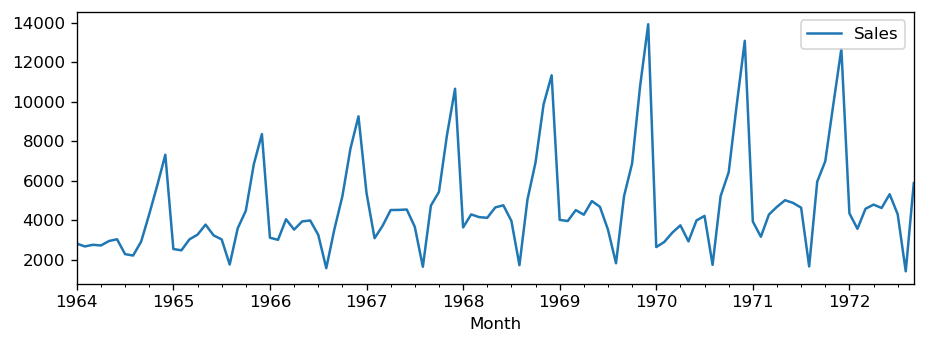

In [10]:
#Plotting the data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df.plot();

From the above plot, we can see there is some seasonality and trend. Holt-Winters model might suits for prediction purposes

In [11]:
df.index.freq = 'MS'

## Splitting into train and test

In [12]:
# Split out the training and testing dataset
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [13]:
# Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

## Modelling using Holt-Winters

### **Option 1: Use trend = additive, seasonal = additive**

#### Step 1 : Import library for Holt Winter

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### Step 2: Instantiate the model

In [15]:
hw = ExponentialSmoothing(train['Sales'], 
                          initialization_method='legacy-heuristic',
                          trend = 'add',
                          seasonal='add',
                          seasonal_periods=12)

#### Step 3: Fit the model

In [16]:
res_hw = hw.fit()

#### Step 4: Make the prediction for in-sample(train set) and forecast the out-sample (test set)

In [17]:
df.loc[train_idx, 'HoltWinters_Train'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters_Test'] = res_hw.forecast(N_test)

#### Step 5: Plotting the prediction of train set and forecast for test test

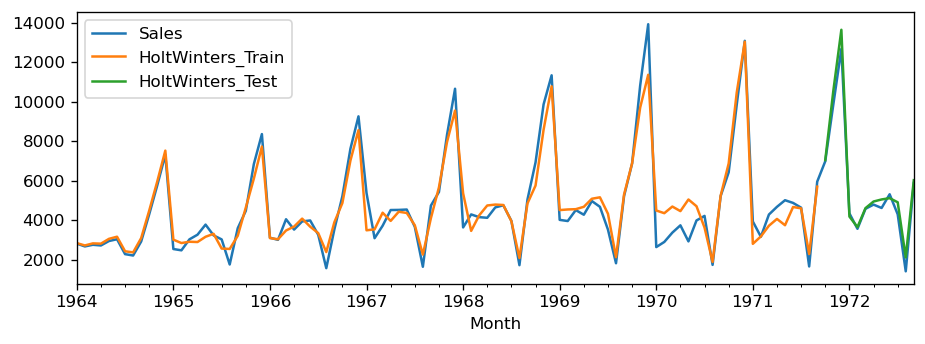

In [18]:
#Plotting the forecast data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df.plot();

#### Step 6: Calculating the metrices

In [19]:
def rmse(y,t):
    return np.sqrt(np.mean((y-t)**2))

In [20]:
def mae(y,t):
    return np.mean(np.abs(y-t))

In [21]:
print("Train RMSE:", rmse(df['Sales'], res_hw.fittedvalues))
print("Test RMSE:", rmse(df['Sales'], res_hw.forecast(N_test)))

Train RMSE: 710.9845228703754
Test RMSE: 463.57771323324454


In [22]:
print("Train MAE:", mae(df['Sales'], res_hw.fittedvalues))
print("Test MAE:", mae(df['Sales'], res_hw.forecast(N_test)))

Train MAE: 499.84340844239887
Test MAE: 353.22783012259225


In [23]:
print("Train Rsquared-score:", r2_score(train['Sales'],res_hw.fittedvalues ))
print("Test Rsquared-score:", r2_score(test['Sales'],res_hw.forecast(N_test)))

Train Rsquared-score: 0.9173444388280613
Test Rsquared-score: 0.9735858983978157


### **Option 2: Use trend = additive, seasonal = multiplicative**

In [24]:
hw_2 = ExponentialSmoothing(train['Sales'], 
                          initialization_method='legacy-heuristic',
                          trend = 'add',
                          seasonal='mul',
                          seasonal_periods=12)

In [25]:
res_hw_2 = hw_2.fit()

In [26]:
df.loc[train_idx, 'HoltWinters_Train_2'] = res_hw_2.fittedvalues
df.loc[test_idx, 'HoltWinters_Test_2'] = res_hw_2.forecast(N_test)

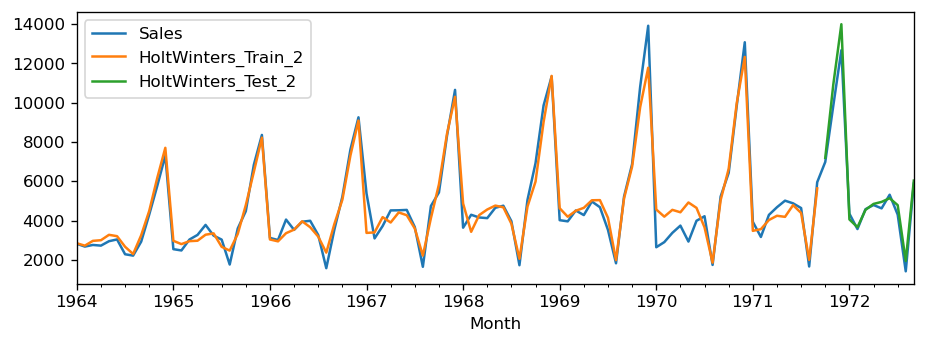

In [27]:
#Plotting the forecast data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df[['Sales','HoltWinters_Train_2','HoltWinters_Test_2']].plot();

In [28]:
print("Train RMSE:", rmse(df['Sales'], res_hw_2.fittedvalues))
print("Test RMSE:", rmse(df['Sales'], res_hw_2.forecast(N_test)))

Train RMSE: 613.5651586268675
Test RMSE: 557.1571699395348


In [29]:
print("Train MAE:", mae(df['Sales'], res_hw_2.fittedvalues))
print("Test MAE:", mae(df['Sales'], res_hw_2.forecast(N_test)))

Train MAE: 429.3059523773081
Test MAE: 396.4661818085065


In [30]:
print("Train Rsquared-score:", r2_score(train['Sales'],res_hw_2.fittedvalues ))
print("Test Rsquared-score:", r2_score(test['Sales'],res_hw_2.forecast(N_test)))

Train Rsquared-score: 0.9384436067550217
Test Rsquared-score: 0.9618454624720415


### **Option 3: Use trend = multiplicative, seasonal = multiplicative**

In [31]:
hw_3 = ExponentialSmoothing(train['Sales'], 
                          initialization_method='legacy-heuristic',
                          trend = 'mul',
                          seasonal='mul',
                          seasonal_periods=12)

In [32]:
res_hw_3 = hw_3.fit()

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [33]:
df.loc[train_idx, 'HoltWinters_Train_3'] = res_hw_3.fittedvalues
df.loc[test_idx, 'HoltWinters_Test_3'] = res_hw_3.forecast(N_test)

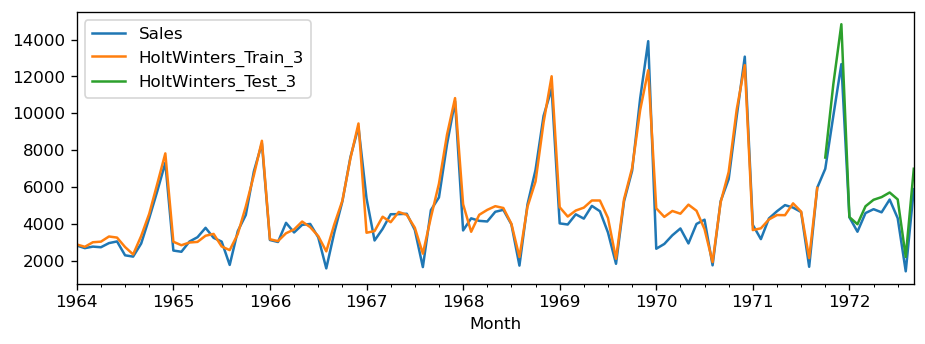

In [34]:
#Plotting the forecast data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df[['Sales','HoltWinters_Train_3','HoltWinters_Test_3']].plot();

In [35]:
print("Train RMSE:", rmse(df['Sales'], res_hw_3.fittedvalues))
print("Test RMSE:", rmse(df['Sales'], res_hw_3.forecast(N_test)))

Train RMSE: 624.5341801834453
Test RMSE: 1012.076843026542


In [36]:
print("Train MAE:", mae(df['Sales'], res_hw_3.fittedvalues))
print("Test MAE:", mae(df['Sales'], res_hw_3.forecast(N_test)))

Train MAE: 448.7271502866084
Test MAE: 826.1453596722581


In [37]:
print("Train Rsquared-score:", r2_score(train['Sales'],res_hw_3.fittedvalues ))
print("Test Rsquared-score:", r2_score(test['Sales'],res_hw_3.forecast(N_test)))

Train Rsquared-score: 0.9362229820522314
Test Rsquared-score: 0.8741023213700576
